## Hillslope diffusion model for Eightmile Lake

### Inputs: Eightmile Lake DEM
### Components: ExponentialWeatherer, DepthDependentDiffuser
### Outputs: Soil flux map

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.enums import Resampling

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.components import ExponentialWeathererIntegrated, DepthDependentDiffuser

/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Step 1) Resample DEM to 30m

In [2]:
current = 2 # meters per pixel
target = 30 # meters per pixel
scale = current / target

with rio.open('./gis/projects/dem/eightmile-lake-watershed-dem-filled.tif') as src:

    # resample data to target shape
    data = src.read(
        out_shape = (
            src.count,
            int(src.height * scale),
            int(src.width * scale)
        ),
        resampling = Resampling.bilinear
    )

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    
dem = data[0]

In [3]:
print(dem.shape)

(836, 1192)


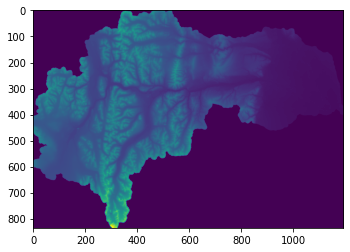

In [4]:
plt.imshow(dem)
plt.show()

### Step 2) Set up model grid and initial conditions

In [5]:
grid = RasterModelGrid((dem.shape[0], dem.shape[1]), target)

In [6]:
grid.add_field('topographic__elevation', np.flip(dem, 0), at = 'node', units = 'm', copy = True, clobber = True)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [7]:
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], 0)

In [8]:
initial_soil = 5 # meters
grid.add_field('bedrock__elevation', grid.at_node['topographic__elevation'] - initial_soil, at = 'node', clobber = True)
grid.add_field('soil__depth', np.full_like(dem, initial_soil), at = 'node', clobber = True)
grid.at_node['soil__depth'] = grid.at_node['topographic__elevation'] - grid.at_node['bedrock__elevation']
grid.add_zeros('soil_production__rate', at = 'node')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

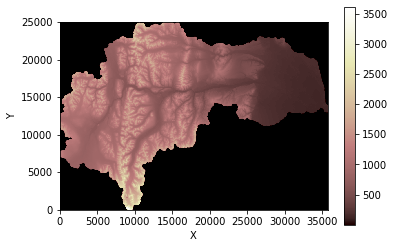

In [9]:
imshow_grid(grid, grid.at_node['topographic__elevation'])

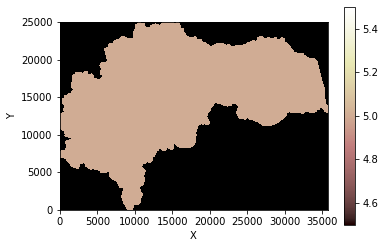

In [10]:
imshow_grid(grid, grid.at_node['soil__depth'])

In [11]:
# Convert fields from float32 to float
# TODO ask Mark what's going on with the components here

grid.at_node['topographic__elevation'] = grid.at_node['topographic__elevation'].astype(float)
grid.at_node['bedrock__elevation'] = grid.at_node['bedrock__elevation'].astype(float)
grid.at_node['soil__depth'] = grid.at_node['soil__depth'].astype(float)

### Step 3) Initialize model components

In [12]:
diff = DepthDependentDiffuser(grid)

In [29]:
nt = 50
dt = 10

initial_soil = grid.at_node['soil__depth']

for i in range(nt):
    diff.run_one_step(dt)
    
final_soil = grid.at_node['soil__depth']

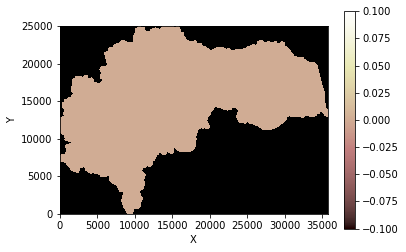

In [30]:
imshow_grid(grid, final_soil - initial_soil)

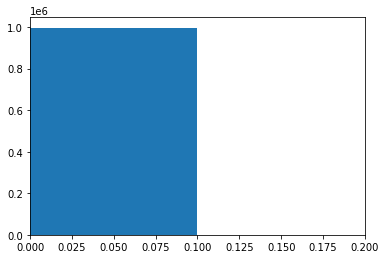

In [31]:
plt.hist(final_soil - initial_soil)
plt.xlim(0, 0.2)
plt.show()